# Lesson 6 - Multi-LoRA


In this lesson, we'll see how to efficiently serve dozens of fine-tuned models together in a single deployment without sacrificing latency.

### Import required packages

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm

### Let's create a new model

We will start with creating an extension to the model from lesson 5. It has a custom helper function for computing the LoRA layer step with multiple LoRAs per batch.

In [2]:
class AbstractMultiLoraModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # hidden_size = 10
        # set this so low to ensure we are not 
        # compute-bound by the linear layer
        # this is only an issue when running on CPU, 
        # for GPUs we can set this much
        # higher and still avoid being compute bound
        self.embedding = torch.nn.Embedding(10, 10)
        self.linear = torch.nn.Linear(10, 10)
        self.lm_head = torch.nn.Linear(10, 10)

    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, rank)
        loras_b: torch.Tensor,           # (num_loras, rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        # y[i] = x[i] @ loras_a[lora_idx] @ loras_b[lora_idx]
        raise NotImplementedError()

    def forward(self, input_ids, loras_a, loras_b, lora_indices):
        x = self.embedding(input_ids)
        x = self.linear_lora(x, loras_a, loras_b, lora_indices)
        x = self.lm_head(x)
        return x

### Using a loop

Our first attempt to infer across multiple LoRAs will be straightforward: just loop over every row in the batch and apply the correct LoRA using an index mapping: `batch_index --> lora_index`.

In [3]:
class LoopMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        for batch_idx, lora_idx in enumerate(lora_indices.numpy()):
            lora_a = loras_a[lora_idx]
            lora_b = loras_b[lora_idx]
            y[batch_idx] += x[batch_idx] @ lora_a @ lora_b
        return y

In [4]:
# toy example of a detokenizer. The vocabular only consists of 10 words (different colors)
detokenizer = [
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "indigo",
    "violet",
    "magenta",
    "marigold",
    "chartreuse",
]

In [5]:
# dummy inputs
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])

In [6]:
torch.manual_seed(42)

In [7]:
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [8]:
model = LoopMultiLoraModel()

### Let's try it!

We will try this over a few random LoRAs using a fixed tensor of input_ids. If our multi-LoRA generation process is working as designed, we should see a variety of different outputs generated as we randomly iterate over the LoRAs.

In [9]:
# constants
bs = 1
num_loras = 64
h = 10
r = 2

# create contiguous blocks for 64 random LoRA weights
loras_a = torch.randn(num_loras, h, r)
loras_b = torch.randn(num_loras, r, h)

for i in range(10):
    # randomize the LoRAs each iteration
    lora_indices = torch.randint(num_loras, (bs,), dtype=torch.long)
    next_token = generate_token(
        model,
        input_ids=input_ids,
        loras_a=loras_a,
        loras_b=loras_b,
        lora_indices=lora_indices,
    )
    print(next_token)

['orange']
['red']
['chartreuse']
['yellow']
['marigold']
['yellow']
['red']
['orange']
['violet']
['red']


### Let's benchmark our multi-LoRA system!

We will measure the average latency to generate a single token as the batch size increases and each element within the batch can have a different LoRA adapter (chosen randomly).

In [10]:
# constants
seq_len = 8
vocab_size = 10
nsamples = 500
max_batch_size = 64


def benchmark(model):
    avg_latencies = []
    for bs in range(1, max_batch_size + 1):
        latencies = []
        for _ in range(nsamples):
            # randomize the inputs and LoRA indices
            input_ids = torch.randint(
                vocab_size, (bs, seq_len), dtype=torch.long)
            lora_indices = torch.randint(
                num_loras, (bs,), dtype=torch.long)

            # measure the end-to-end latency for 
            # generating a single token
            t0 = time.time()
            next_token = generate_token(
                model,
                input_ids=input_ids,
                loras_a=loras_a,
                loras_b=loras_b,
                lora_indices=lora_indices,
            )
            latencies.append(time.time() - t0)

        # average the latency across all the samples
        latency_s = sum(latencies) / len(latencies)
        avg_latencies.append(latency_s)
        print(bs, latency_s)
    return avg_latencies

**Note:** Your results might differ from those shown in the video, but they will still follow the same pattern.

In [11]:
avg_latencies_loop = benchmark(model)

1 0.00014488935470581056
2 0.0001754908561706543
3 0.00020029401779174806
4 0.00023006963729858398
5 0.00024810171127319337
6 0.000269777774810791
7 0.00026999282836914063
8 0.00028768396377563477
9 0.0003127150535583496
10 0.0003352322578430176
11 0.0003598198890686035
12 0.0004108600616455078
13 0.0003997950553894043
14 0.000423302173614502
15 0.00048558473587036134
16 0.0005128374099731446
17 0.0005435285568237305
18 0.0005623121261596679
19 0.0005869626998901367
20 0.0006118478775024414
21 0.0006484065055847168
22 0.0006609888076782226
23 0.0006923408508300781
24 0.0007081737518310546
25 0.000748018741607666
26 0.0007656512260437011
27 0.0007935700416564942
28 0.0008170123100280761
29 0.00083306884765625
30 0.0008387703895568848
31 0.000846853256225586
32 0.0008303599357604981
33 0.0008612732887268066
34 0.0008372917175292969
35 0.0009250717163085938
36 0.0008795142173767089
37 0.0009753961563110352
38 0.0009267535209655761
39 0.0010216002464294434
40 0.0010033421516418457
41 0.000

### Let's visualize it!

**Note**: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

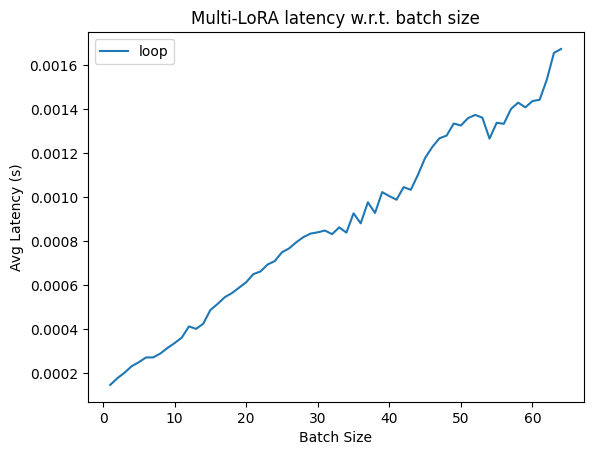

In [12]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()

### Let's vectorize the LoRA computation

We will vectorize the LoRA computation by:

1. Gather the LoRA weight for each batch into a single tensor using `torch.index_select`.
2. Apply LoRA computation once for the entire input tensor.

In [13]:
class GatheredMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        
        # gather the LoRA weights into a new tensor and apply
        lora_a = torch.index_select(loras_a, 0, lora_indices) # (batch_size, in_features, lora_rank)
        lora_b = torch.index_select(loras_b, 0, lora_indices) # (batch_size, lora_rank, out_features)
        y += x @ lora_a @ lora_b
        return y

In [14]:
model = GatheredMultiLoraModel()

**Note:** Your results might differ from those shown in the video, but they will still follow the same pattern.

In [15]:
avg_latencies_gathered = benchmark(model)

1 0.000121185302734375
2 0.0018098158836364745
3 0.0018058671951293945
4 0.0018023066520690917
5 0.002186208724975586
6 0.001993211269378662
7 0.0023740048408508302
8 0.0021868891716003416
9 0.0023793702125549316
10 0.0020001859664916994
11 0.002374429702758789
12 0.002399974822998047
13 0.0027756481170654297
14 0.0026138687133789064
15 0.002766648769378662
16 0.0027861714363098143
17 0.0027637133598327635
18 0.0022157993316650392
19 0.0022189240455627443
20 0.002584878921508789
21 0.002791665077209473
22 0.002800752639770508
23 0.003014521598815918
24 0.0033634257316589354
25 0.0031716485023498536
26 0.003377305507659912
27 0.0029747986793518064
28 0.0033731980323791506
29 0.0030079007148742674
30 0.0033766279220581053
31 0.003567594051361084
32 0.003185673713684082
33 0.002983306884765625
34 0.002797126293182373
35 0.003003598213195801
36 0.002994875431060791
37 0.0027978992462158203
38 0.002982069492340088
39 0.0031693973541259764
40 0.0028010344505310057
41 0.0031869263648986817
42

### Let's visualize it!

**Note**: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

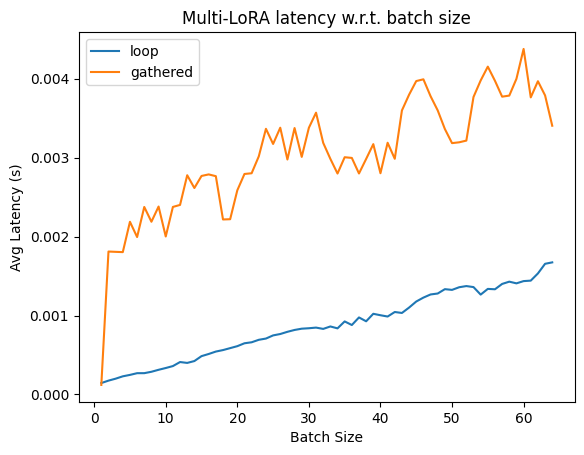

In [16]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")
plt.plot(x, avg_latencies_gathered, label="gathered")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()